# Vanilla Neural Network
This notebook outlines the various steps necessary to build a simple neural network using Python and Numpy. 

## Import Packages

In [84]:
import numpy as np
import pandas as pd
import sys
import seaborn as sb
import matplotlib.pyplot as plt 
from vanilla_nn_class import VanillaNN

%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

## Loading the Data
Load the hourly data with Pandas and take a look at the first five entries. Each row is a datarecord with each colomn as a feature. We will eliminate and normalize features in the next few steps.

In [85]:
data_path = 'dataset/hour.csv'
ride_data = pd.read_csv(data_path)
ride_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Visualize Some Data
Let's take a look at 10 days worth of data. Remember to multiply by 24 since we are using hourly data. 

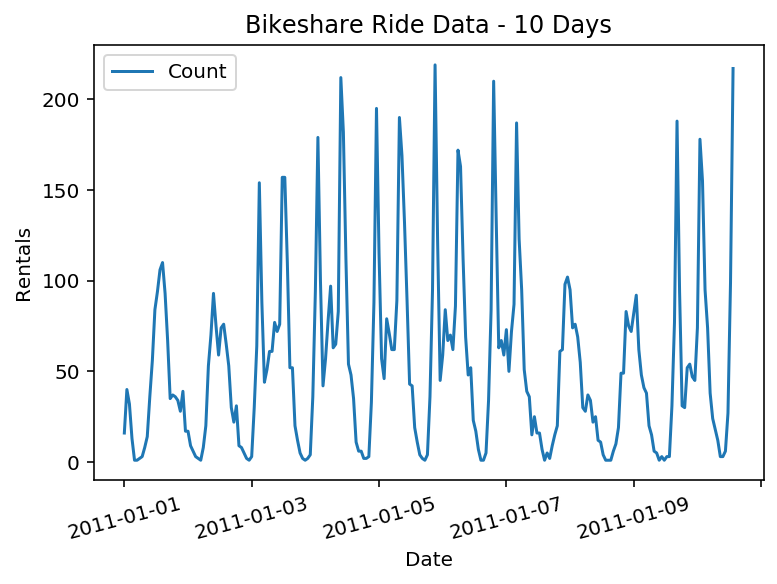

In [86]:
days = 24*10
ride_data[:days].plot(x='dteday', y='cnt', label='Count')
plt.title(label='Bikeshare Ride Data - 10 Days')
plt.ylabel('Rentals')
plt.xlabel('Date')
plt.xticks(rotation = 15)
plt.show()

## Dummy Variables  
Since much of the data is categorical we need to convert it to dummy variables using Pandas `pd.get_dummies()` function. We drop unnecessary data eliminating noise in the model.

In [87]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

for field in dummy_fields:
    dummies = pd.get_dummies(ride_data[field], prefix=field, drop_first=False)
    ride_data = pd.concat([ride_data, dummies], axis=1)

fields_to_drop = ['dteday', 'instant', 'season', 'weathersit', 'weekday', 'atemp', 'workingday', 'mnth', 'hr']
data = ride_data.drop(fields_to_drop, axis=1)
data.head()


,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


## Scaling Data
We will scale the continuous data so the model can process it easier, while saving the values to use later. 

$$scaled\ data=\frac{x\ - mean(X)}{std(X)}$$

In [88]:
cont_fields = ['temp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
scaled_features = {} # create empty dictionary
for field in cont_fields:
    mean = data[field].mean()
    std = data[field].std()
    scaled_features[field] = [mean, std] # store for later to unormalize data
    data.loc[:,field] = (data[field] - mean) / std # normalize data

data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1


## Test, Train, Validation Data
Split the dataset into training, validation and testing sets. Remove the last 21 days from the dataset to use for testing after the model is trained.

In [89]:
# test data
test_data = data[-21*24:]

# remove the last 30 days 
data = data[:-21*24]

# targets (X)
target_fields = ['cnt', 'casual', 'registered'] 
targets = data[target_fields]

# features (y)
features = data.drop(target_fields, axis=1)

# test features
test_features = test_data.drop(target_fields, axis=1)
# test targets
test_targets = test_data[target_fields]


In [90]:
# training and vaildation data
train_features = features[:-60*24]
train_targets = targets[:-60*24]
valid_features = features[-60*24:]
valid_targets = targets[-60*24:]

In [91]:
print('Train Features - {} <---> Train Targets - {}'.format(train_features.shape, train_targets.shape))

Train Features - (15435, 56) <---> Train Targets - (15435, 3)


In [92]:
def MSE(y, Y):
    return np.mean((y - Y)**2)

## Training the Model
The folowing uses the `VanillaNN()` class and trains the model with the user supplied parameters. Data is split into batches of size 128. Feel free to tinker with epochs and learning rate. 

Model uses a sigmoid activation function applied to the hidden layer input. Since we are doing a regression analysis the output 


- Sigmoid activation function

$$\sigma(x) = \frac{1}{1+e^{-x}}$$

- Hidden layer output formula

$$\hat{y} = \sigma(w_1 x_1 + w_2 x_2 + b)$$

- Error function where $y$ is the target value

$$Error = y - \hat{y}$$



- The function that updates the weights  


$$ w_i \longrightarrow w_i + \alpha (y - \hat{y}) x_i$$

$$ b \longrightarrow b + \alpha (y - \hat{y})$$


In [93]:
# define parameters
learning_rate = 1.28
hidden_nodes = 10
output_nodes = 1
epochs = 2500

# intantiate model 
model = VanillaNN(train_features.shape[1], hidden_nodes, output_nodes, learning_rate)
losses = {'train': [], 'validation': []}
for e in range(epochs):
    batch = np.random.choice(train_features.index, size=128)
    X = train_features.iloc[batch].values # features
    y = train_targets.iloc[batch]['cnt'] # targets
    # train model
    model.train(X, y)
    # cacluculate loss
    train_loss = MSE(model.forward(train_features).T, train_targets['cnt'].values)
    valid_loss = MSE(model.forward(valid_features).T, valid_targets['cnt'].values)

    losses['train'].append(train_loss)
    losses['validation'].append(valid_loss)
    # print
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * e/float(epochs)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(valid_loss)[:5])
    sys.stdout.flush()

Progress: 100.0% ... Training loss: 0.064 ... Validation loss: 0.141

## Training and Validation Loss
Visualize the loss over time.  

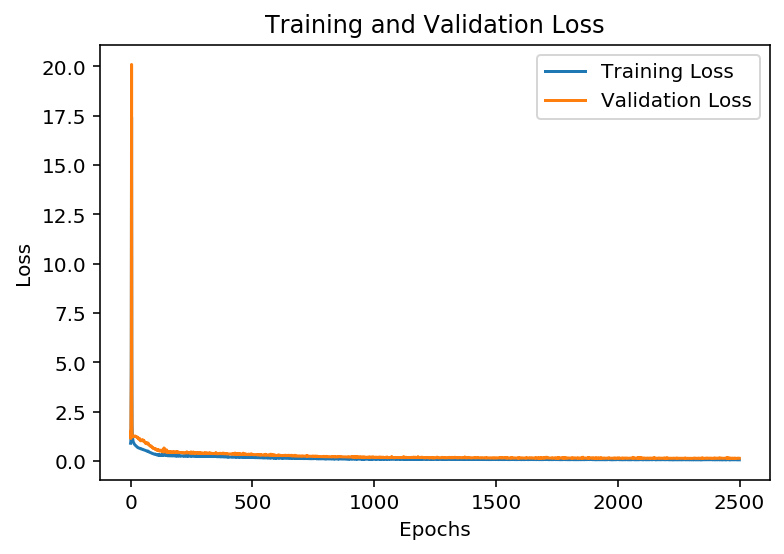

In [94]:
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['validation'], label='Validation Loss')
plt.legend()
plt.title(label='Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
fname = 'imgs/loss_01.jpg'
plt.savefig(fname, dpi=150)




## Test the Prediction
Test the prediction with the test data. Notice that the model has trouble predicting towards the end of December. Why do you think this is the case?

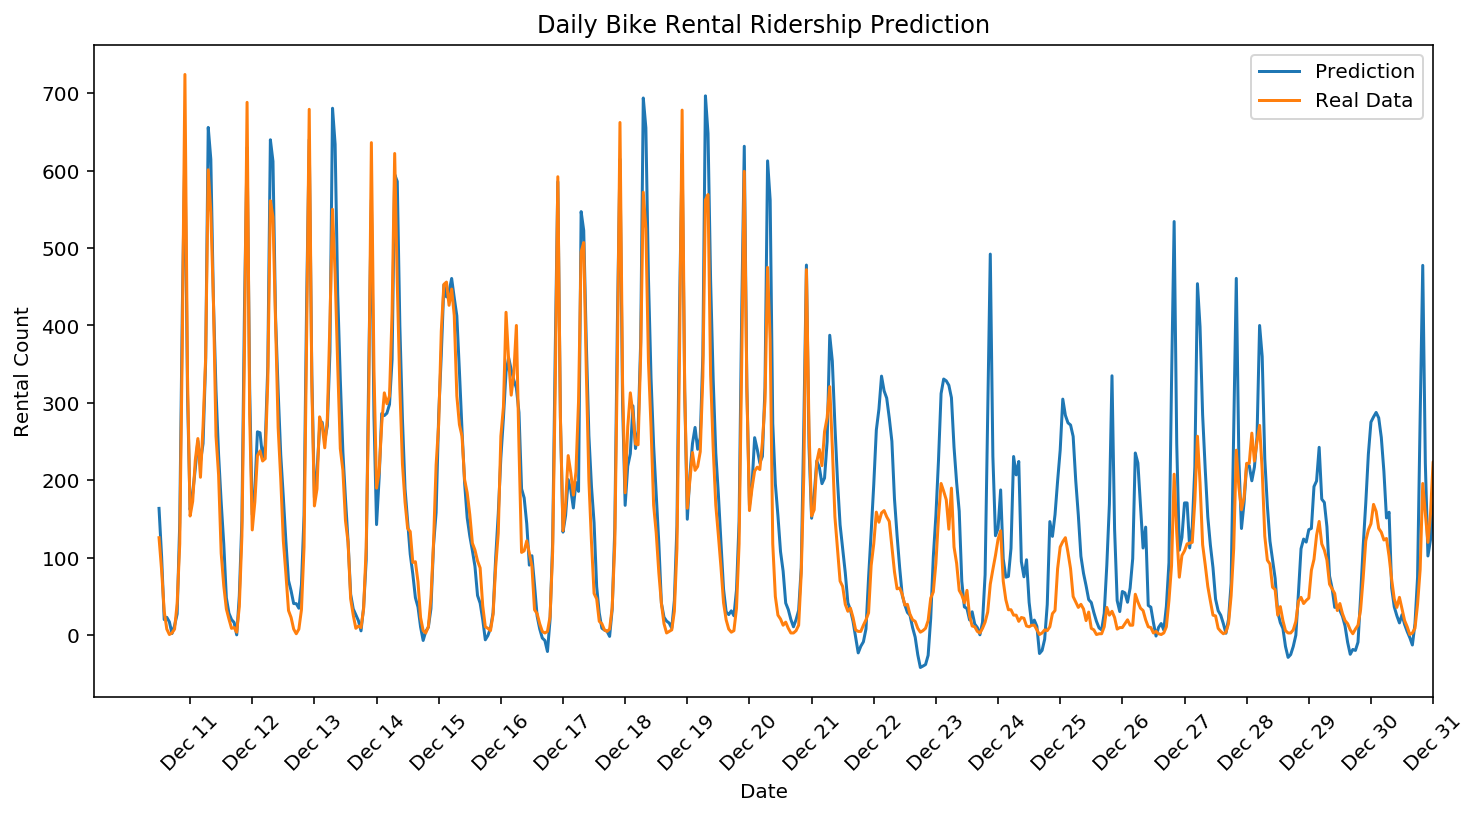

In [95]:
fig, ax = plt.subplots(figsize=(12, 6))

mean, std = scaled_features['cnt']
preds = model.forward(test_features).T*std + mean
ax.plot(preds[0], label='Prediction')
ax.plot((test_targets['cnt']).values*std + mean, label='Real Data')
ax.set_xlim(right=len(preds))
ax.legend()

dates = pd.to_datetime(ride_data.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)
plt.title(label='Daily Bike Rental Ridership Prediction')
plt.xlabel('Date')
plt.ylabel('Rental Count')
fname = 'imgs/pred_01.jpg'
plt.savefig(fname, dpi=150)
